# **Ciencia de Datos en Producción — Entregable 2**
### Notebook Colab: **`transformacion_eda_colab_v2-2.ipynb`**

**Dataset:** `BD_creditos (2).xlsx` (créditos)

**Qué incluye (alineado al notebook ejemplo `eda.ipynb`):**
- Importación y configuración.
- Carga de datos + descripción general.
- Nulos, duplicados, valores atípicos (tratamiento tipo *EDA*).
- Limpieza / estandarización de variables.
- Features derivadas.
- EDA: univariable, bivariado (target vs numéricas/categóricas), multivariado.
- Heurística simple + métricas.
- Conclusiones + insights cuantificados.

> Nota: `Pago_atiempo = 1` significa **al día**; `Pago_atiempo = 0` significa **mora**.


## **Importar librerías**

In [1]:
from __future__ import annotations

from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)

# configuración para que solo se muestren 2 decimales (como en el ejemplo)
pd.set_option("display.float_format", "{:.2f}".format)


## **Configuración mínima**

In [2]:
config = {
    "target": "Pago_atiempo",
    "tendencia_permitida": ["Creciente", "Estable", "Decreciente"],
    # columnas con alto riesgo de leakage (normalmente se conocen *después* del desempeño del crédito)
    "leakage_cols": ["saldo_mora", "saldo_total", "saldo_principal", "saldo_mora_codeudor"],
}

TARGET = config["target"]
print("✅ TARGET:", TARGET)


✅ TARGET: Pago_atiempo


## **Cargar datos**


In [3]:
# --- Subir archivo en Colab ---
try:
    from google.colab import files
    uploaded = files.upload()  # selecciona BD_creditos (2).xlsx
    file_path = next(iter(uploaded))
except Exception:
    # fallback si no estás en Colab (ejecución local)
    file_path = "BD_creditos (2).xlsx"

print("📄 Archivo:", file_path)


Saving BD_creditos (2).xlsx to BD_creditos (2).xlsx
📄 Archivo: BD_creditos (2).xlsx


In [4]:
df_raw = pd.read_excel(file_path)
print("✅ Dataset cargado")
print("Shape:", df_raw.shape)
df_raw.head()


✅ Dataset cargado
Shape: (10763, 23)


,tipo_credito,fecha_prestamo,capital_prestado,plazo_meses,edad_cliente,tipo_laboral,salario_cliente,total_otros_prestamos,cuota_pactada,puntaje,...,saldo_mora,saldo_total,saldo_principal,saldo_mora_codeudor,creditos_sectorFinanciero,creditos_sectorCooperativo,creditos_sectorReal,promedio_ingresos_datacredito,tendencia_ingresos,Pago_atiempo
0,4,2025-01-07 14:40:36,1852560.00,12,32,Empleado,3500000,1000000,128650,95.23,...,0.00,0.00,NaN,NaN,0,0,0,916148.00,Creciente,1
1,4,2025-01-09 11:18:48,3181080.00,6,34,Empleado,5000000,2000000,441817,95.23,...,0.00,0.00,NaN,NaN,0,0,0,4473774.00,Creciente,1
2,9,2024-12-26 18:52:57,670200.00,5,34,Independiente,5000000,2000000,108632,95.23,...,0.00,274561.00,274561.00,NaN,2,0,1,NaN,NaN,1
3,9,2024-12-04 14:20:50,506806.80,2,25,Independiente,3000000,900000,199684,95.23,...,0.00,27564.00,27564.00,NaN,1,0,6,NaN,NaN,1
4,4,2025-04-30 18:41:57,999780.00,10,26,Empleado,2000000,600000,92509,95.23,...,0.00,0.00,NaN,NaN,0,0,0,61000.00,Creciente,1


## **Descripción del dataframe**

In [5]:
# información general
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10763 entries, 0 to 10762
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   tipo_credito                   10763 non-null  int64         
 1   fecha_prestamo                 10763 non-null  datetime64[ns]
 2   capital_prestado               10763 non-null  float64       
 3   plazo_meses                    10763 non-null  int64         
 4   edad_cliente                   10763 non-null  int64         
 5   tipo_laboral                   10763 non-null  object        
 6   salario_cliente                10763 non-null  int64         
 7   total_otros_prestamos          10763 non-null  int64         
 8   cuota_pactada                  10763 non-null  int64         
 9   puntaje                        10763 non-null  float64       
 10  puntaje_datacredito            10757 non-null  float64       
 11  cant_creditosvi

In [6]:
# tamaño del dataframe
df_raw.shape

(10763, 23)

In [7]:
# algunos registros
df_raw.sample(5, random_state=7)

,tipo_credito,fecha_prestamo,capital_prestado,plazo_meses,edad_cliente,tipo_laboral,salario_cliente,total_otros_prestamos,cuota_pactada,puntaje,...,saldo_mora,saldo_total,saldo_principal,saldo_mora_codeudor,creditos_sectorFinanciero,creditos_sectorCooperativo,creditos_sectorReal,promedio_ingresos_datacredito,tendencia_ingresos,Pago_atiempo
2700,4,2025-01-09 18:41:58,960000.00,6,62,Empleado,2500000,1000000,133333,95.23,...,0.00,36083.00,36083.00,0.00,4,0,0,4171755.00,Decreciente,1
1876,4,2025-08-10 11:39:08,4094400.00,6,45,Empleado,3500000,950000,607076,95.23,...,0.00,0.00,0.00,0.00,1,0,0,7059391.00,Creciente,1
2043,4,2025-03-29 17:21:59,2100000.00,18,40,Empleado,1300000,400000,117242,95.23,...,0.00,0.00,0.00,0.00,1,0,2,772558.00,Creciente,1
4245,4,2025-04-04 09:37:46,5990400.00,12,36,Empleado,1200000,500000,471411,95.23,...,0.00,16591.00,16591.00,0.00,1,0,2,933473.00,Creciente,1
9413,4,2025-07-02 11:23:56,851880.00,6,31,Empleado,2300000,300000,127581,95.23,...,0.00,1134.00,1134.00,0.00,1,0,0,NaN,NaN,1


### Nulos por columna (porcentaje)

In [8]:
nulls_perc = (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
nulls_perc.sort_values(ascending=False).head(15).to_frame("null_%")


,null_%
tendencia_ingresos,27.24
promedio_ingresos_datacredito,27.22
saldo_mora_codeudor,5.48
saldo_principal,3.76
saldo_mora,1.45
saldo_total,1.45
puntaje_datacredito,0.06
salario_cliente,0.00
tipo_laboral,0.00
edad_cliente,0.00


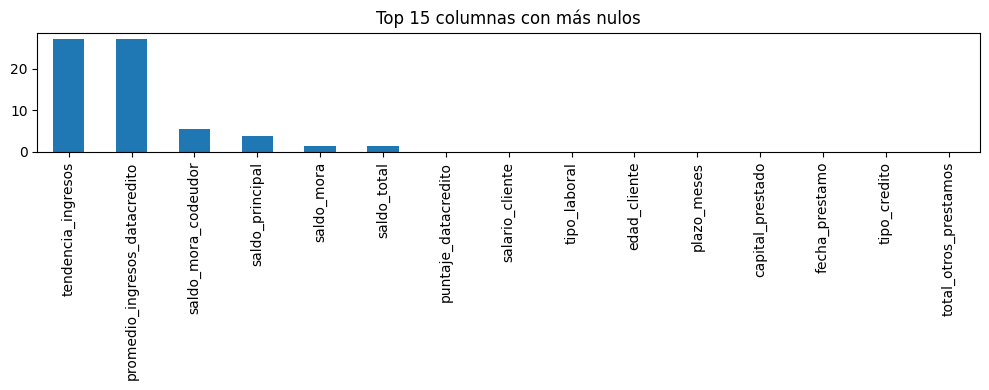

In [9]:
plt.figure(figsize=(10, 4))
nulls_perc.sort_values(ascending=False).head(15).plot(kind="bar", title="Top 15 columnas con más nulos", legend=False)
plt.tight_layout()
plt.show()


### Variable target: **`Pago_atiempo`**
`1` = al día, `0` = mora.

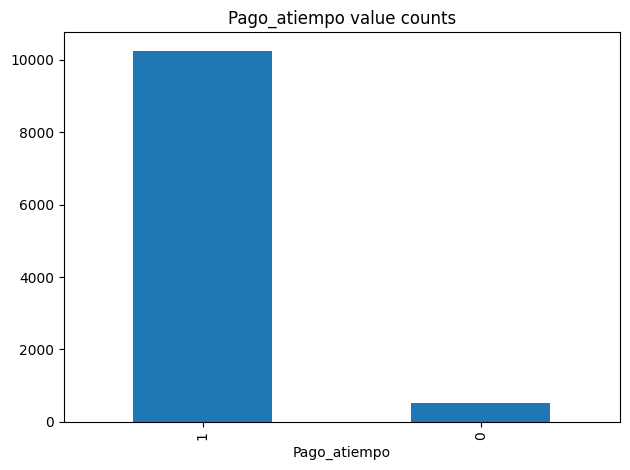

Tasa de mora global (Pago_atiempo=0): 4.75%


In [10]:
df_raw[TARGET].value_counts().plot(kind="bar", title=f"{TARGET} value counts")
plt.tight_layout()
plt.show()

tasa_mora = (df_raw[TARGET] == 0).mean()
print(f"Tasa de mora global (Pago_atiempo=0): {tasa_mora:.2%}")


### Duplicados
Antes del análisis, revisamos si hay registros duplicados.

In [11]:
dup = df_raw.duplicated().sum()
print("Duplicados:", dup)

df_nodup = df_raw.copy()
if dup > 0:
    df_nodup.drop_duplicates(inplace=True, keep="first")
    print("✅ Duplicados eliminados. Nuevo shape:", df_nodup.shape)
else:
    print("✅ No hay duplicados. Usaremos df_nodup = df_raw.")


Duplicados: 0
✅ No hay duplicados. Usaremos df_nodup = df_raw.


## **Valores atípicos (outliers) y limpieza**
El objetivo aquí es **no borrar registros**, sino **marcar / poner NaN** cuando el valor es claramente inválido o extremo para el análisis.

### 1) Reglas de negocio básicas
- `salario_cliente = 0` → NaN (se considera dato faltante).
- `total_otros_prestamos = 0` **sí es válido** (cliente sin otros préstamos).
- `puntaje` fuera de 0–100 → NaN.
- `puntaje_datacredito` fuera de 150–950 → NaN.
- `promedio_ingresos_datacredito <= 0` → NaN.

### 2) Outliers extremos (percentiles 1–99)
En variables monetarias, valores fuera del rango [p1, p99] se convierten a NaN para evitar distorsión gráfica.


In [12]:
df = df_nodup.copy()

# --- flags de calidad (trazabilidad) ---
df["flag_salario_cero"] = (df["salario_cliente"] == 0).astype(int)

# 1) Reglas básicas
df.loc[df["salario_cliente"] <= 0, "salario_cliente"] = np.nan
df.loc[df["total_otros_prestamos"] < 0, "total_otros_prestamos"] = np.nan  # 0 es válido

df.loc[~df["puntaje"].between(0, 100), "puntaje"] = np.nan
df.loc[~df["puntaje_datacredito"].between(150, 950), "puntaje_datacredito"] = np.nan

df.loc[df["promedio_ingresos_datacredito"] <= 0, "promedio_ingresos_datacredito"] = np.nan

# tendencia_ingresos: solo categorías válidas
valid_trend = set(config["tendencia_permitida"])
df["tendencia_ingresos"] = df["tendencia_ingresos"].where(df["tendencia_ingresos"].isin(valid_trend), np.nan)

# 2) Outliers extremos en monetarias (p1-p99) -> NaN
mon_cols = ["salario_cliente", "total_otros_prestamos", "capital_prestado", "cuota_pactada", "promedio_ingresos_datacredito"]
for c in mon_cols:
    if c not in df.columns:
        continue
    s = df[c].dropna()
    if len(s) < 50:
        continue
    p1, p99 = s.quantile([0.01, 0.99])
    df.loc[(df[c] < p1) | (df[c] > p99), c] = np.nan

print("✅ Limpieza aplicada. Top nulos:")
(df.isna().mean().sort_values(ascending=False).head(10) * 100).round(2).to_frame("null_%")


✅ Limpieza aplicada. Top nulos:


,null_%
promedio_ingresos_datacredito,28.76
tendencia_ingresos,27.78
saldo_mora_codeudor,5.48
saldo_principal,3.76
salario_cliente,2.04
capital_prestado,2.01
cuota_pactada,2.01
puntaje_datacredito,1.48
saldo_total,1.45
saldo_mora,1.45


### Nota de *leakage*
Variables como `saldo_mora`, `saldo_total`, `saldo_principal`, `saldo_mora_codeudor` pueden reflejar información posterior al comportamiento del crédito.
Por eso creamos:
- `df` (EDA general)
- `df_model` (sin columnas potencialmente leakage)


In [13]:
leakage_cols = [c for c in config["leakage_cols"] if c in df.columns]
print("Columnas potencialmente leakage:", leakage_cols)

df_model = df.drop(columns=leakage_cols)
print("✅ df_model shape:", df_model.shape)


Columnas potencialmente leakage: ['saldo_mora', 'saldo_total', 'saldo_principal', 'saldo_mora_codeudor']
✅ df_model shape: (10763, 20)


## **Tipos correctos**

In [29]:
# Fecha
df_model["fecha_prestamo"] = pd.to_datetime(df_model["fecha_prestamo"], errors="coerce")

# Categóricas
for col in ["tipo_laboral", "tendencia_ingresos", "tipo_credito"]:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype("category")

# Target
df_model[TARGET] = df_model[TARGET].astype(int)

df_model.dtypes


,0
tipo_credito,category
fecha_prestamo,datetime64[ns]
capital_prestado,float64
plazo_meses,int64
edad_cliente,int64
tipo_laboral,category
salario_cliente,float64
total_otros_prestamos,float64
cuota_pactada,float64
puntaje,float64


## **Atributos derivados (feature engineering)**

In [30]:
df_fe = df_model.copy()
eps = 1e-9

# ratios de capacidad de pago
df_fe["ratio_cuota_salario"] = df_fe["cuota_pactada"] / (df_fe["salario_cliente"] + eps)
df_fe["ratio_capital_salario"] = df_fe["capital_prestado"] / (df_fe["salario_cliente"] + eps)
df_fe["ratio_otros_prestamos_salario"] = df_fe["total_otros_prestamos"] / (df_fe["salario_cliente"] + eps)

df_fe["dti_aprox"] = (df_fe["capital_prestado"] + df_fe["total_otros_prestamos"]) / (df_fe["salario_cliente"] + eps)

# features de fecha
df_fe["anio_prestamo"] = df_fe["fecha_prestamo"].dt.year.astype("Int64")
df_fe["mes_prestamo"] = df_fe["fecha_prestamo"].dt.month.astype("Int64")
df_fe["dia_semana_prestamo"] = df_fe["fecha_prestamo"].dt.day_name().astype("category")

# antigüedad (en días) respecto a la fecha actual del curso (Bogotá, 2026-02-20)
ref_date = pd.Timestamp("2026-02-20")
df_fe["antiguedad_prestamo_dias"] = (ref_date.normalize() - df_fe["fecha_prestamo"].dt.normalize()).dt.days.astype("Int64")

# buckets de edad
df_fe["edad_bucket"] = pd.cut(
    df_fe["edad_cliente"],
    bins=[17, 25, 35, 45, 55, 65, 120],
    labels=["18-25", "26-35", "36-45", "46-55", "56-65", "66+"],
)

# créditos por sector (totales y proporciones)
sector_cols = ["creditos_sectorFinanciero", "creditos_sectorCooperativo", "creditos_sectorReal"]
df_fe["creditos_sector_total"] = df_fe[sector_cols].sum(axis=1)

for c in sector_cols:
    df_fe[f"pct_{c}"] = df_fe[c] / (df_fe["creditos_sector_total"] + eps)

df_fe.head()


,tipo_credito,fecha_prestamo,capital_prestado,plazo_meses,edad_cliente,tipo_laboral,salario_cliente,total_otros_prestamos,cuota_pactada,puntaje,...,dti_aprox,anio_prestamo,mes_prestamo,dia_semana_prestamo,antiguedad_prestamo_dias,edad_bucket,creditos_sector_total,pct_creditos_sectorFinanciero,pct_creditos_sectorCooperativo,pct_creditos_sectorReal
0,4,2025-01-07 14:40:36,1852560.00,12,32,Empleado,3500000.00,1000000.00,128650.00,95.23,...,0.82,2025,1,Tuesday,409,26-35,0,0.00,0.00,0.00
1,4,2025-01-09 11:18:48,3181080.00,6,34,Empleado,5000000.00,2000000.00,441817.00,95.23,...,1.04,2025,1,Thursday,407,26-35,0,0.00,0.00,0.00
2,9,2024-12-26 18:52:57,670200.00,5,34,Independiente,5000000.00,2000000.00,108632.00,95.23,...,0.53,2024,12,Thursday,421,26-35,3,0.67,0.00,0.33
3,9,2024-12-04 14:20:50,506806.80,2,25,Independiente,3000000.00,900000.00,199684.00,95.23,...,0.47,2024,12,Wednesday,443,18-25,7,0.14,0.00,0.86
4,4,2025-04-30 18:41:57,999780.00,10,26,Empleado,2000000.00,600000.00,92509.00,95.23,...,0.80,2025,4,Wednesday,296,26-35,0,0.00,0.00,0.00


### **Análisis univariable**

**Variables numéricas**

In [16]:
num_cols = list(df_fe.select_dtypes(include=["number"]).columns)
num_cols = [c for c in num_cols if c != TARGET]  # sin el target

df_fe[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
capital_prestado,10547.00,2352061.39,1547930.40,469063.20,1244880.00,1921920.00,3053326.80,8875200.00
plazo_meses,10763.00,10.58,6.63,2.00,6.00,10.00,12.00,90.00
edad_cliente,10763.00,43.95,15.06,19.00,33.00,42.00,53.00,123.00
salario_cliente,10543.00,3942035.45,3546403.36,1000000.00,2000000.00,3000000.00,4750000.00,39279939.00
total_otros_prestamos,10655.00,1432963.58,1647449.10,0.00,500000.00,1000000.00,2000000.00,17913000.00
cuota_pactada,10547.00,232976.77,164538.81,51492.00,122089.00,182863.00,284294.50,1112633.00
puntaje,10628.00,92.47,11.82,0.05,95.23,95.23,95.23,95.23
puntaje_datacredito,10604.00,791.50,50.69,287.00,758.00,792.00,826.00,947.00
cant_creditosvigentes,10763.00,5.73,3.98,0.00,3.00,5.00,8.00,62.00
huella_consulta,10763.00,4.23,3.06,0.00,2.00,4.00,6.00,29.00


**Variables categóricas**

In [17]:
cat_cols = list(df_fe.select_dtypes(include=["object", "category", "bool"]).columns)

cat_cols = [c for c in cat_cols if c != TARGET]

df_fe[cat_cols].describe().T


,count,unique,top,freq
tipo_credito,10763,6,4,7747
tipo_laboral,10763,2,Empleado,6754
tendencia_ingresos,7773,3,Creciente,5294
dia_semana_prestamo,10763,7,Thursday,1899
edad_bucket,10613,6,36-45,3176


### **Bivariate Analysis**
Es importante revisar la relación entre la variable target y las otras variables.

**Target vs Variables numéricas**

Para que sea legible (y rápido en Colab) usamos un set de variables numéricas “foco”.

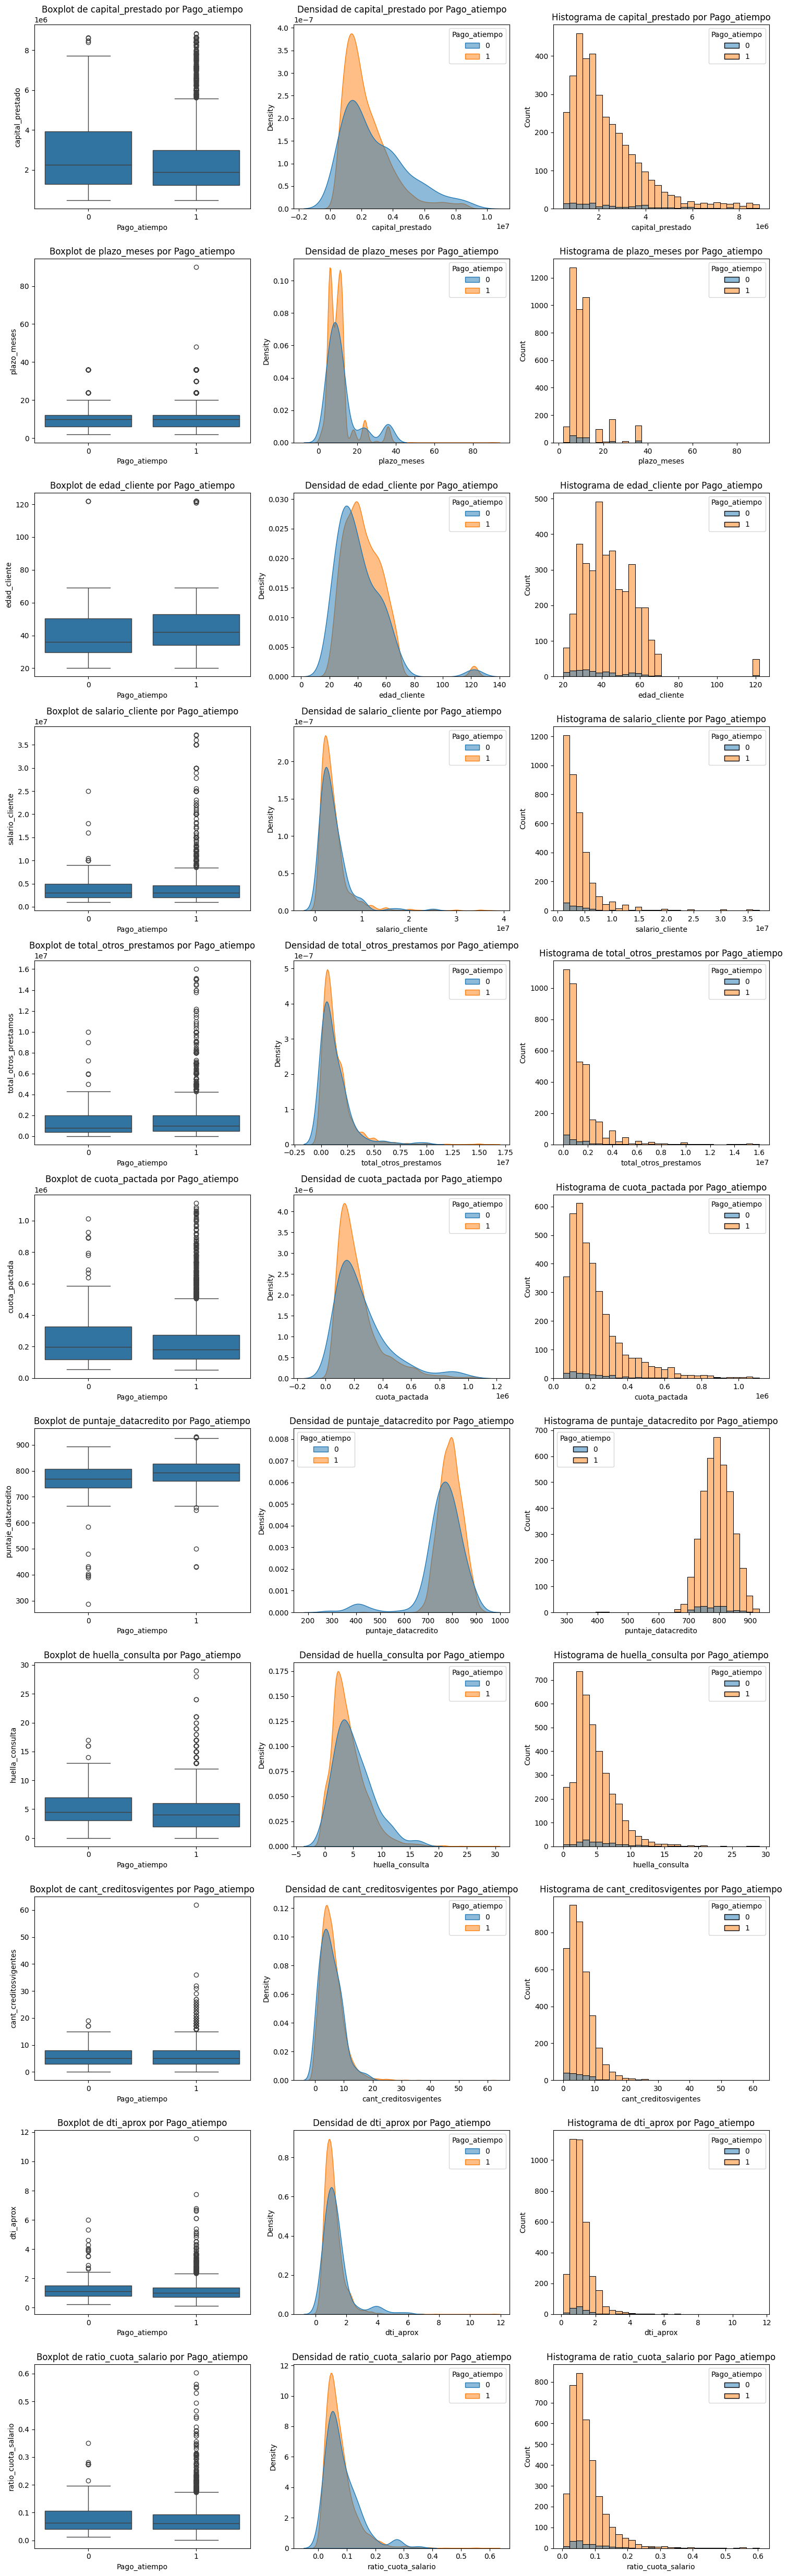

In [18]:
num_focus = [
    "capital_prestado","plazo_meses","edad_cliente","salario_cliente",
    "total_otros_prestamos","cuota_pactada","puntaje_datacredito",
    "huella_consulta","cant_creditosvigentes","dti_aprox","ratio_cuota_salario"
]
num_focus = [c for c in num_focus if c in df_fe.columns]

# muestreo para mejorar rendimiento en kde/hist
plot_df = df_fe[num_focus + [TARGET]].dropna(subset=[TARGET]).sample(min(4000, len(df_fe)), random_state=7)

fig, axes = plt.subplots(nrows=len(num_focus), ncols=3, figsize=(15, 4.5 * len(num_focus)))

if len(num_focus) == 1:
    axes = np.array([axes])  # asegurar 2D

for i, col in enumerate(num_focus):
    sns.boxplot(x=TARGET, y=col, data=plot_df, ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot de {col} por {TARGET}")

    sns.kdeplot(
        data=plot_df, x=col, hue=TARGET,
        fill=True, common_norm=False, alpha=0.5,
        ax=axes[i, 1],
    )
    axes[i, 1].set_title(f"Densidad de {col} por {TARGET}")

    sns.histplot(data=plot_df, x=col, hue=TARGET, bins=30, kde=False, alpha=0.5, ax=axes[i, 2])
    axes[i, 2].set_title(f"Histograma de {col} por {TARGET}")

plt.tight_layout()
plt.show()


**Tasa de mora por decil (variables numéricas)**

Esto complementa el análisis: si la mora sube/baja a través de deciles, hay señal predictiva.

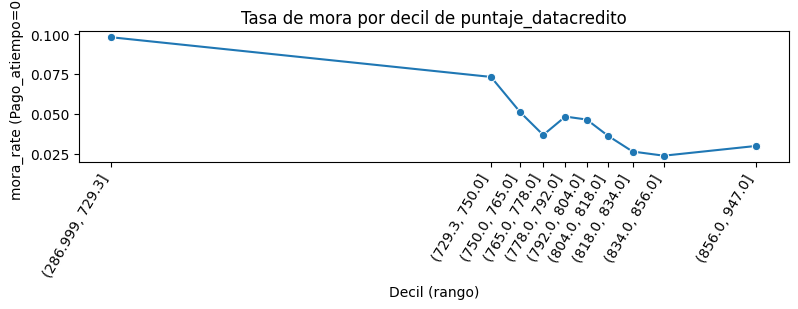

,bin_label,mora_rate
0,"(286.999, 729.3]",0.10
1,"(729.3, 750.0]",0.07
2,"(750.0, 765.0]",0.05
3,"(765.0, 778.0]",0.04
4,"(778.0, 792.0]",0.05
5,"(792.0, 804.0]",0.05
6,"(804.0, 818.0]",0.04
7,"(818.0, 834.0]",0.03
8,"(834.0, 856.0]",0.02
9,"(856.0, 947.0]",0.03


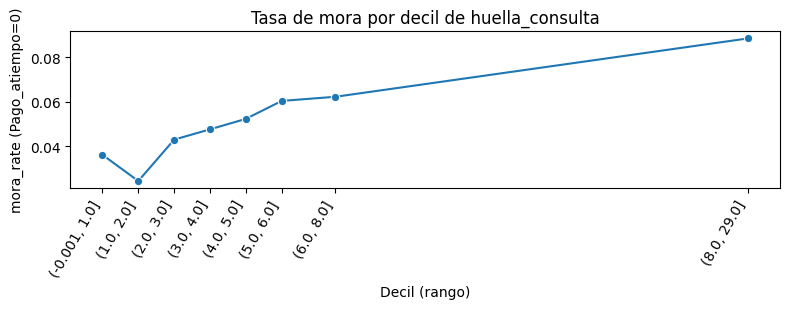

,bin_label,mora_rate
0,"(-0.001, 1.0]",0.04
1,"(1.0, 2.0]",0.02
2,"(2.0, 3.0]",0.04
3,"(3.0, 4.0]",0.05
4,"(4.0, 5.0]",0.05
5,"(5.0, 6.0]",0.06
6,"(6.0, 8.0]",0.06
7,"(8.0, 29.0]",0.09


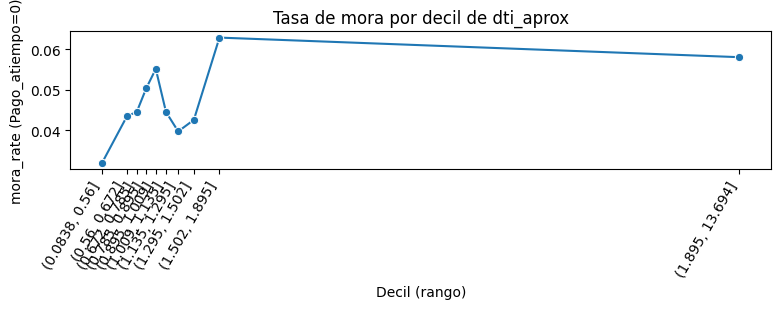

,bin_label,mora_rate
0,"(0.0838, 0.56]",0.03
1,"(0.56, 0.672]",0.04
2,"(0.672, 0.785]",0.04
3,"(0.785, 0.895]",0.05
4,"(0.895, 1.009]",0.06
5,"(1.009, 1.135]",0.04
6,"(1.135, 1.295]",0.04
7,"(1.295, 1.502]",0.04
8,"(1.502, 1.895]",0.06
9,"(1.895, 13.694]",0.06


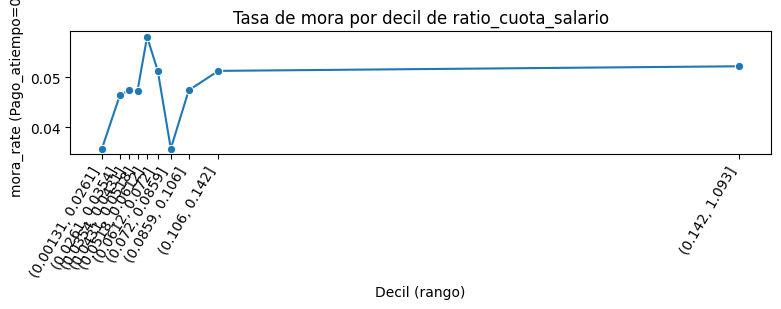

,bin_label,mora_rate
0,"(0.00131, 0.0261]",0.04
1,"(0.0261, 0.0354]",0.05
2,"(0.0354, 0.0431]",0.05
3,"(0.0431, 0.0518]",0.05
4,"(0.0518, 0.0612]",0.06
5,"(0.0612, 0.072]",0.05
6,"(0.072, 0.0859]",0.04
7,"(0.0859, 0.106]",0.05
8,"(0.106, 0.142]",0.05
9,"(0.142, 1.093]",0.05


In [19]:
def default_rate_by_bin(df_in: pd.DataFrame, col: str, q: int = 10) -> pd.DataFrame:
    tmp = df_in[[col, TARGET]].dropna().copy()
    tmp["bin"] = pd.qcut(tmp[col], q=q, duplicates="drop")

    rate = (
        tmp.groupby("bin", observed=True)[TARGET]
        .apply(lambda x: (x == 0).mean())
        .reset_index(name="mora_rate")
    )
    rate["bin_mid"] = rate["bin"].apply(lambda iv: (iv.left + iv.right) / 2)
    rate["bin_label"] = rate["bin"].astype(str)
    rate = rate.sort_values("bin_mid").reset_index(drop=True)
    return rate

for col in ["puntaje_datacredito","huella_consulta","dti_aprox","ratio_cuota_salario"]:
    if col not in df_fe.columns:
        continue
    rate = default_rate_by_bin(df_fe, col, q=10)

    plt.figure(figsize=(8, 3.2))
    sns.lineplot(data=rate, x="bin_mid", y="mora_rate", marker="o")
    plt.xticks(rate["bin_mid"], rate["bin_label"], rotation=60, ha="right")
    plt.title(f"Tasa de mora por decil de {col}")
    plt.ylabel("mora_rate (Pago_atiempo=0)")
    plt.xlabel("Decil (rango)")
    plt.tight_layout()
    plt.show()

    display(rate[["bin_label","mora_rate"]])


**Target vs Variables categóricas**

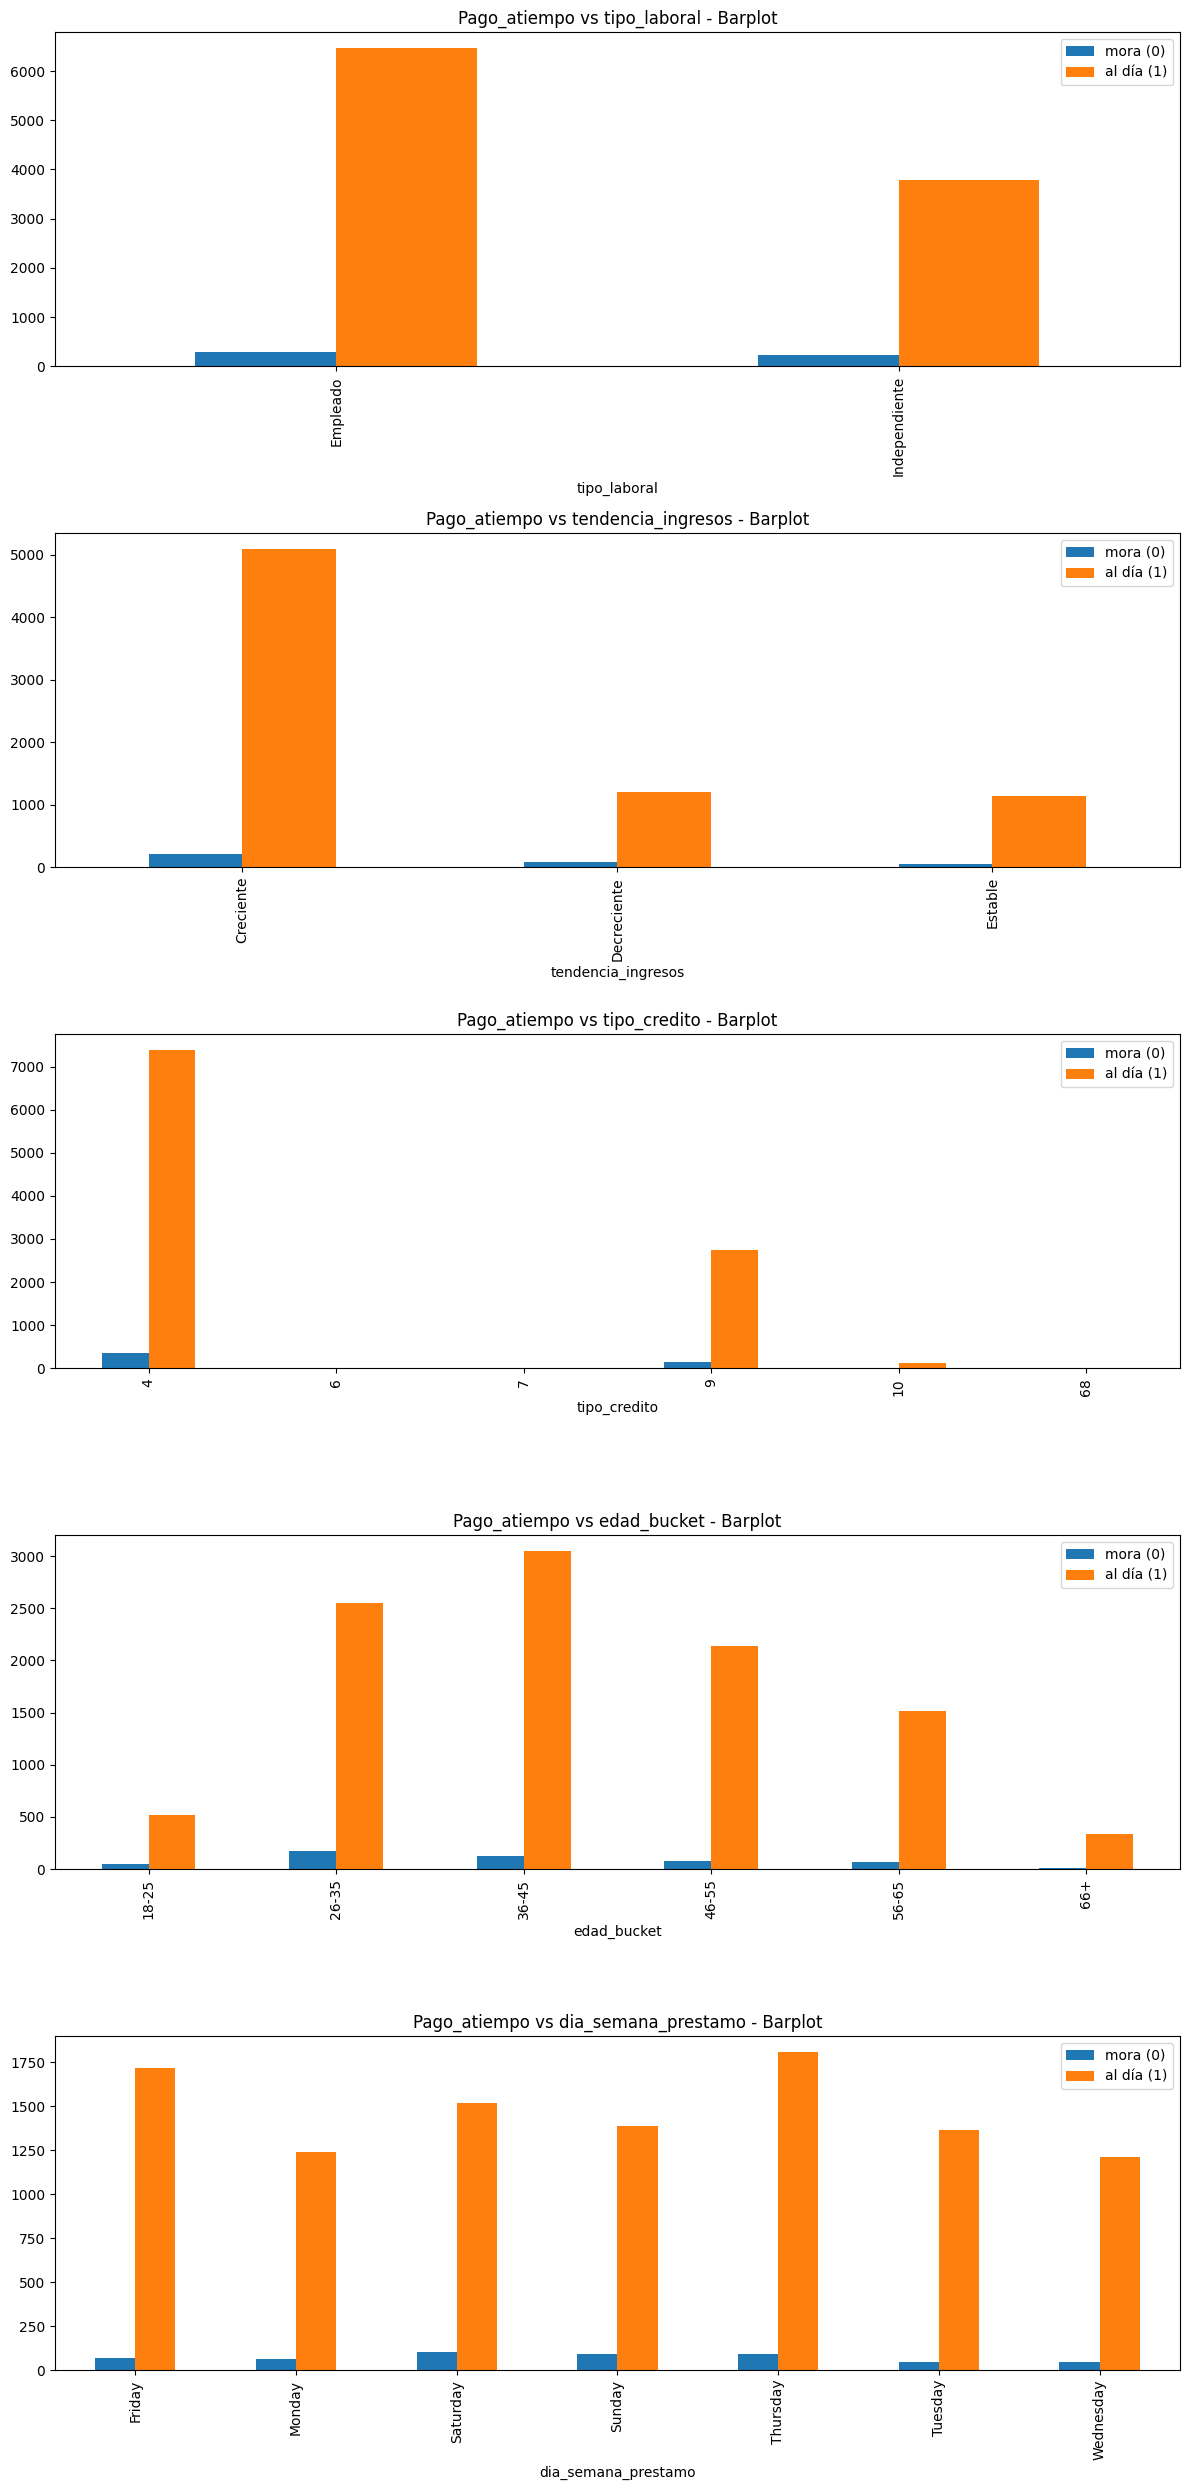

In [20]:
cat_focus = ["tipo_laboral", "tendencia_ingresos", "tipo_credito", "edad_bucket", "dia_semana_prestamo"]
cat_focus = [c for c in cat_focus if c in df_fe.columns]

fig, axes = plt.subplots(nrows=len(cat_focus), ncols=1, figsize=(12, 5 * max(len(cat_focus), 1)))
if len(cat_focus) == 1:
    axes = [axes]

for i, col in enumerate(cat_focus):
    pd.crosstab(df_fe[col], df_fe[TARGET]).plot(kind="bar", ax=axes[i], title=f"{TARGET} vs {col} - Barplot")
    axes[i].legend(["mora (0)", "al día (1)"])

plt.tight_layout()
plt.show()


### **Multivariate Analysis**

#### 1) Categóricas vs Target (tablas y porcentajes)
Usamos `crosstab` con gradiente + tasa de mora por categoría.

In [21]:
temp = df_fe.copy()
temp[TARGET] = temp[TARGET].astype(float)

for col in cat_focus:
    ct = pd.crosstab(df_fe[col], df_fe[TARGET], margins=True)
    display(
        ct.style.background_gradient(cmap="coolwarm")
        .set_caption(f"{TARGET} vs {col} (conteos)")
    )
    # % mora por categoría
    stats = df_fe.groupby(col, observed=True)[TARGET].agg(
        on_time_rate="mean",
        n="size"
    ).sort_values("on_time_rate")
    stats["mora_rate"] = 1 - stats["on_time_rate"]
    display((stats[["mora_rate","on_time_rate","n"]] * [100,100,1]).rename(columns={"mora_rate":"mora_%","on_time_rate":"al_dia_%"}))


Pago_atiempo,0,1,All
tipo_laboral,,,
Empleado,290,6464,6754
Independiente,221,3788,4009
All,511,10252,10763


,mora_%,al_dia_%,n
tipo_laboral,,,
Independiente,5.51,94.49,4009
Empleado,4.29,95.71,6754


Pago_atiempo,0,1,All
tendencia_ingresos,,,
Creciente,207,5087,5294
Decreciente,81,1210,1291
Estable,55,1133,1188
All,343,7430,7773


,mora_%,al_dia_%,n
tendencia_ingresos,,,
Decreciente,6.27,93.73,1291
Estable,4.63,95.37,1188
Creciente,3.91,96.09,5294


Pago_atiempo,0,1,All
tipo_credito,,,
4,363,7384,7747
6,9,12,21
7,0,2,2
9,136,2740,2876
10,3,113,116
68,0,1,1
All,511,10252,10763


,mora_%,al_dia_%,n
tipo_credito,,,
6,42.86,57.14,21
9,4.73,95.27,2876
4,4.69,95.31,7747
10,2.59,97.41,116
7,0.00,100.00,2
68,0.00,100.00,1


Pago_atiempo,0,1,All
edad_bucket,,,
18-25,50,518,568
26-35,169,2554,2723
36-45,128,3048,3176
46-55,76,2140,2216
56-65,66,1516,1582
66+,11,337,348
All,500,10113,10613


,mora_%,al_dia_%,n
edad_bucket,,,
18-25,8.80,91.20,568
26-35,6.21,93.79,2723
56-65,4.17,95.83,1582
36-45,4.03,95.97,3176
46-55,3.43,96.57,2216
66+,3.16,96.84,348


Pago_atiempo,0,1,All
dia_semana_prestamo,,,
Friday,70,1719,1789
Monday,65,1242,1307
Saturday,101,1520,1621
Sunday,93,1388,1481
Thursday,91,1808,1899
Tuesday,47,1365,1412
Wednesday,44,1210,1254
All,511,10252,10763


,mora_%,al_dia_%,n
dia_semana_prestamo,,,
Sunday,6.28,93.72,1481
Saturday,6.23,93.77,1621
Monday,4.97,95.03,1307
Thursday,4.79,95.21,1899
Friday,3.91,96.09,1789
Wednesday,3.51,96.49,1254
Tuesday,3.33,96.67,1412


#### 2) Numéricas vs numéricas (grid)
Para no saturar, usamos un subconjunto de variables numéricas clave.

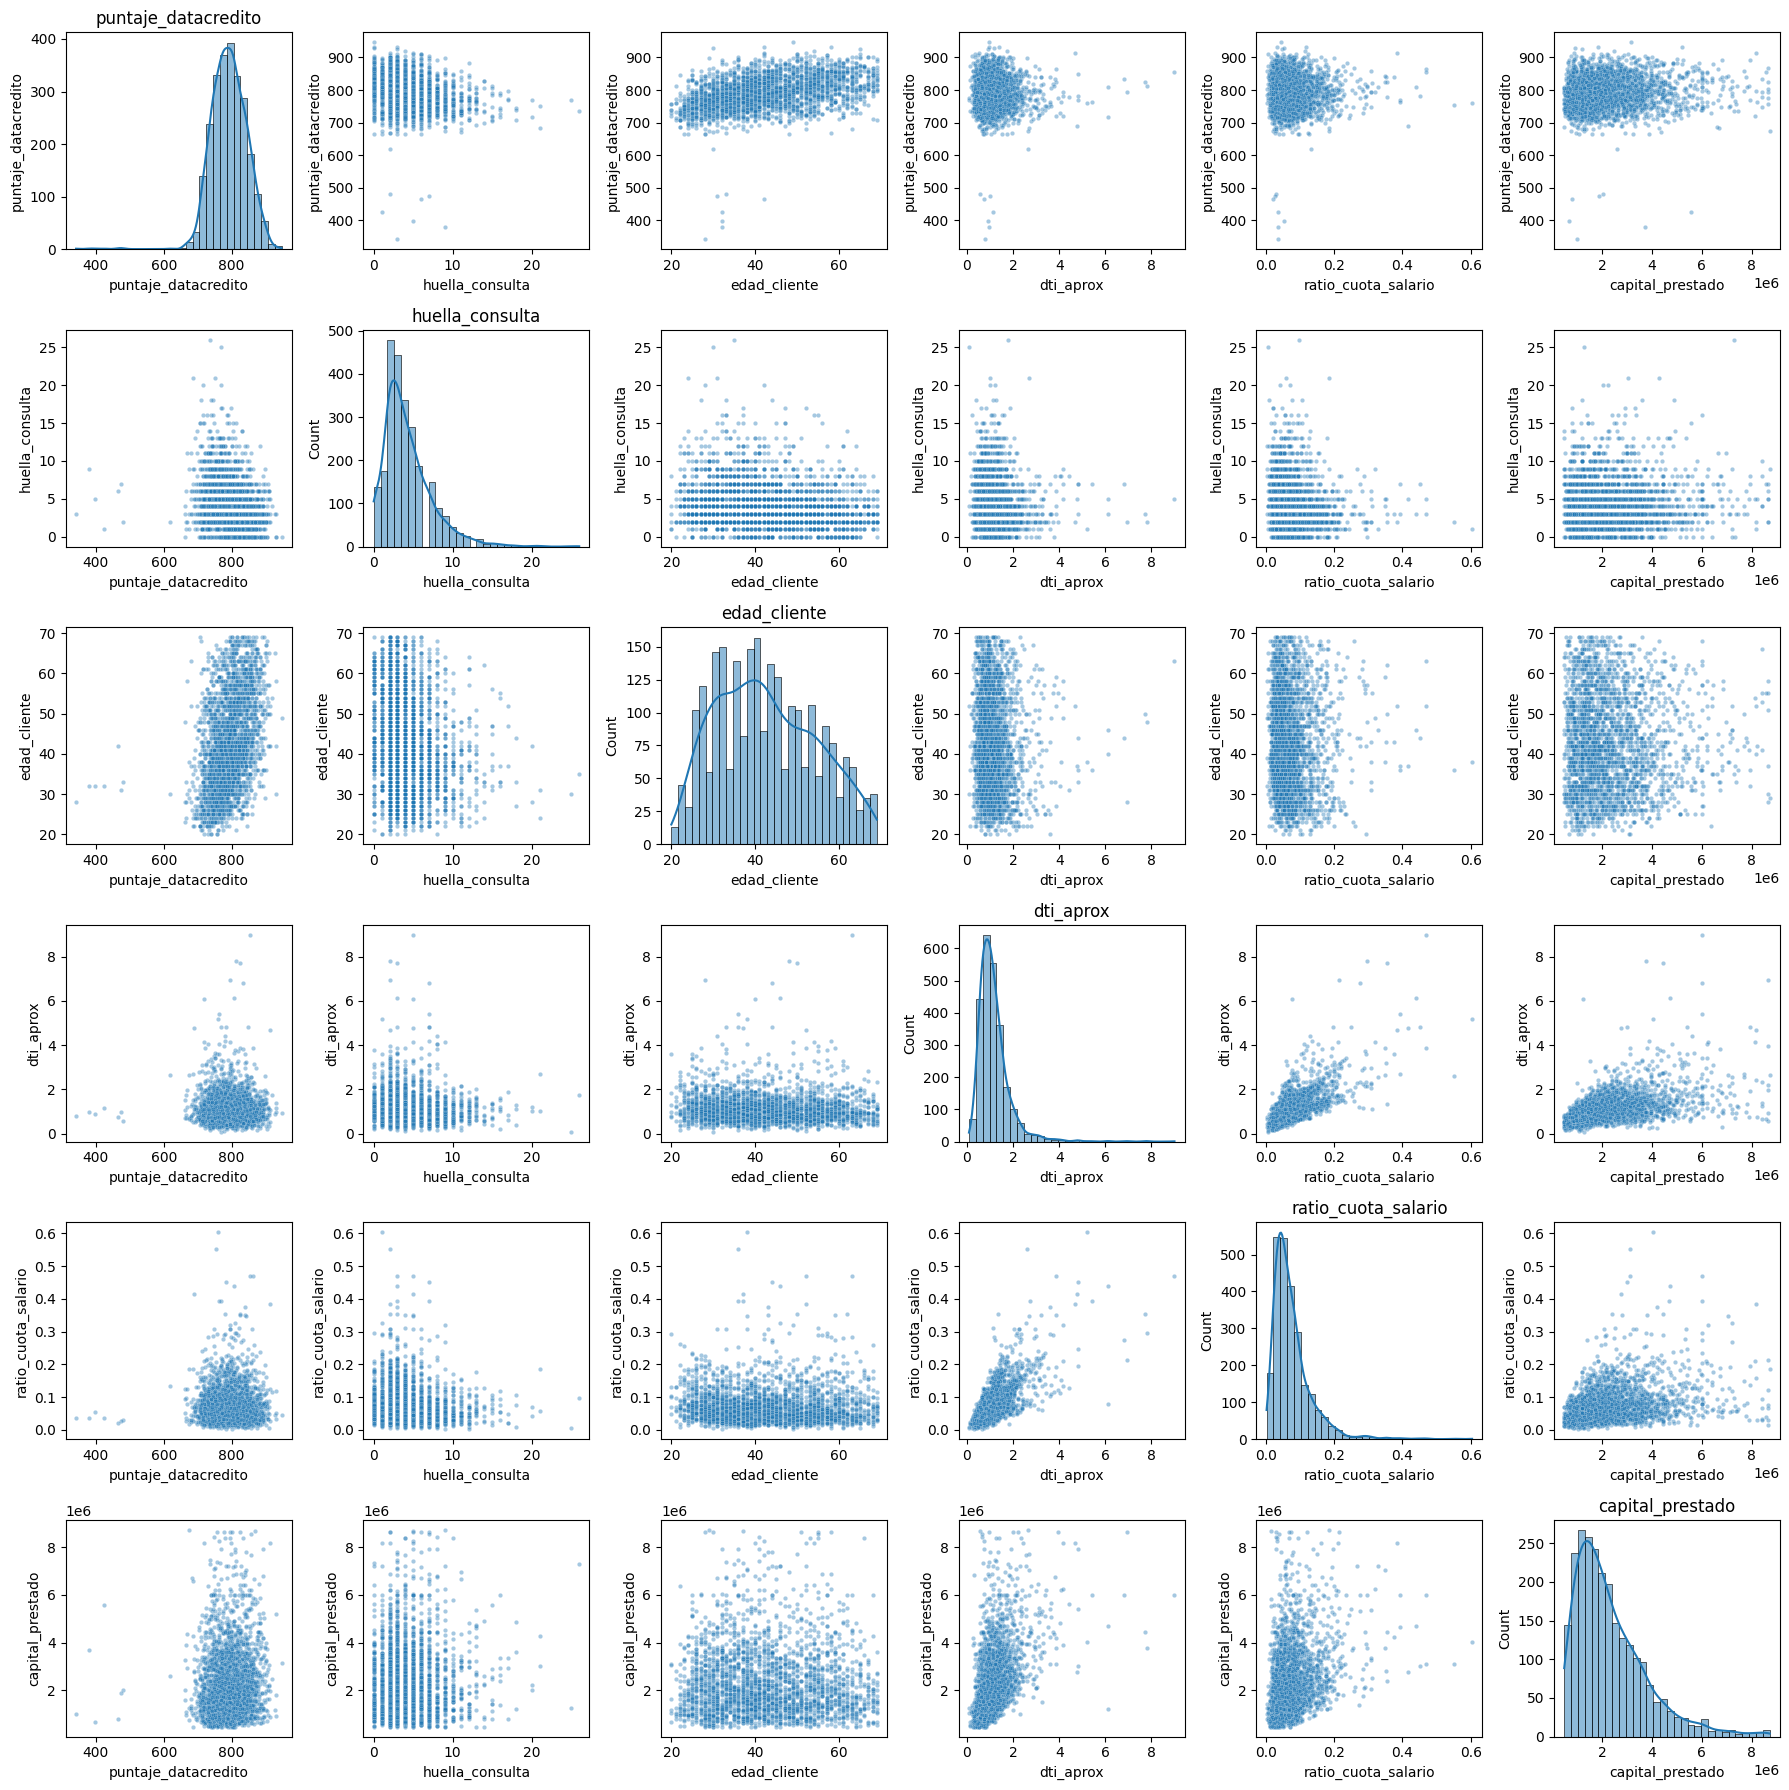

In [22]:
grid_vars = ["puntaje_datacredito","huella_consulta","edad_cliente","dti_aprox","ratio_cuota_salario","capital_prestado"]
grid_vars = [c for c in grid_vars if c in df_fe.columns]

sample_grid = df_fe[grid_vars].dropna().sample(min(2500, df_fe[grid_vars].dropna().shape[0]), random_state=7)

num_vars = len(grid_vars)
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(3 * num_vars, 3 * num_vars))

for i, col1 in enumerate(grid_vars):
    for j, col2 in enumerate(grid_vars):
        ax = axes[i, j]
        if i == j:
            sns.histplot(sample_grid[col1], bins=30, kde=True, ax=ax)
            ax.set_title(f"{col1}")
        else:
            sns.scatterplot(x=sample_grid[col2], y=sample_grid[col1], ax=ax, s=10, alpha=0.4)

        if j == 0:
            ax.set_ylabel(col1)
        if i == num_vars - 1:
            ax.set_xlabel(col2)

plt.tight_layout()
plt.show()


#### 3) Pairplot (muestra) con `hue=Pago_atiempo`

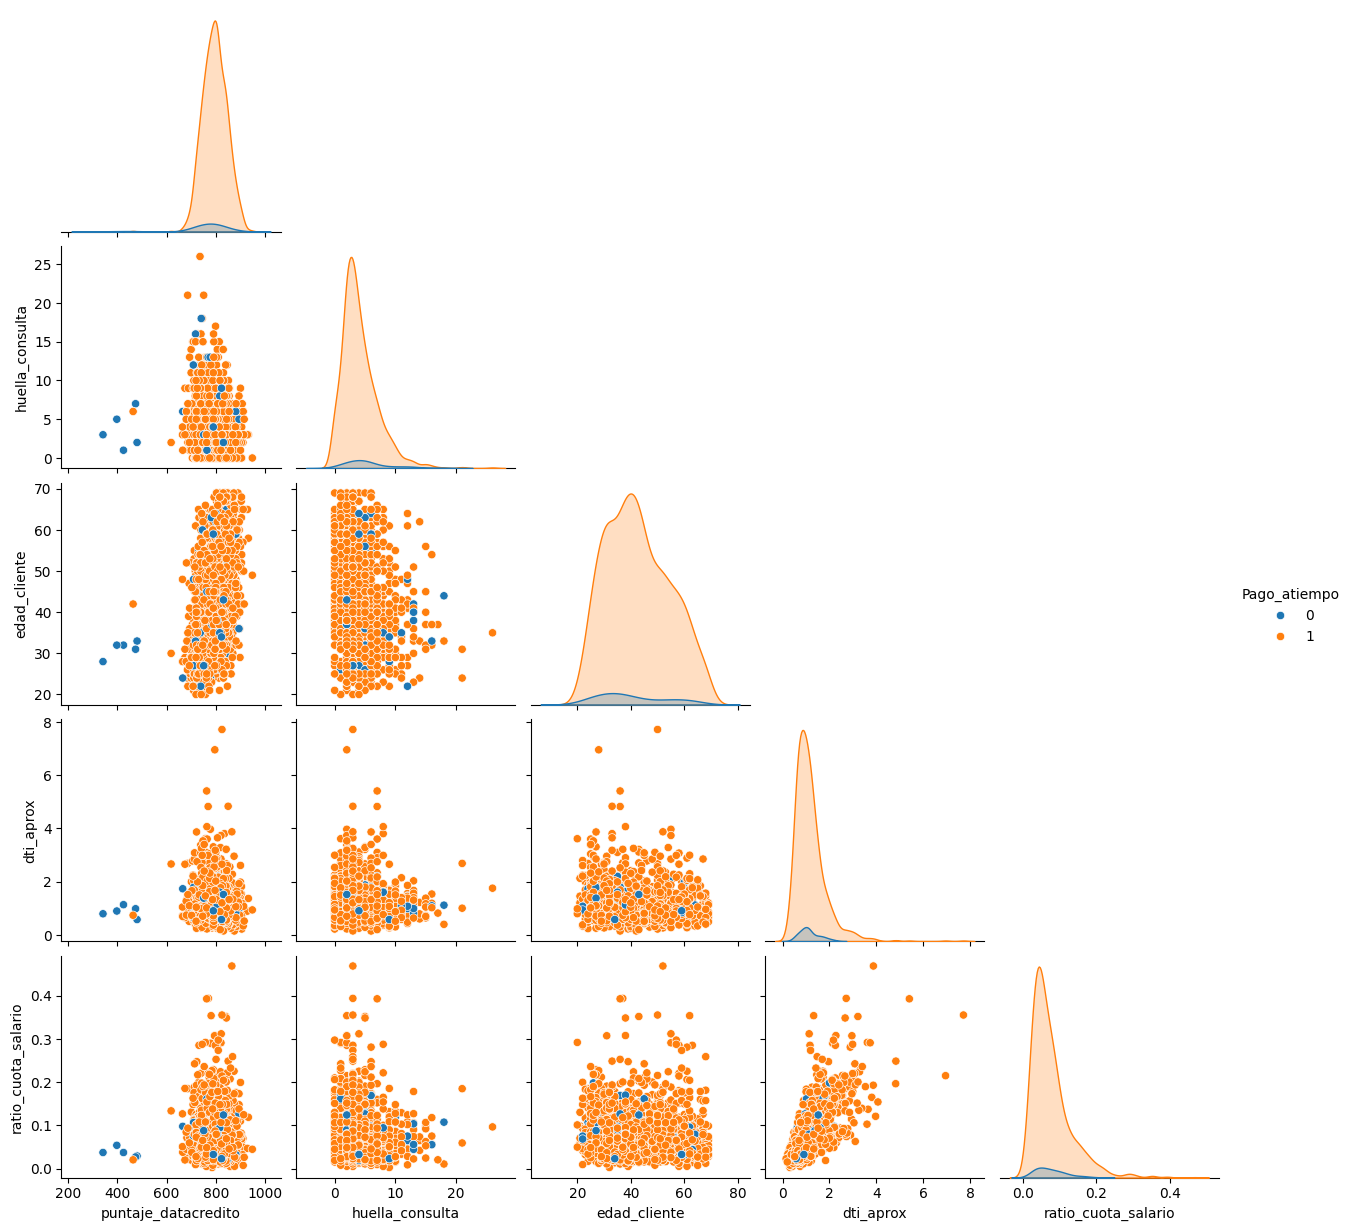

In [23]:
pair_vars = ["puntaje_datacredito","huella_consulta","edad_cliente","dti_aprox","ratio_cuota_salario"]
pair_vars = [c for c in pair_vars if c in df_fe.columns]

pair_df = df_fe[pair_vars + [TARGET]].dropna().sample(min(1500, df_fe.dropna(subset=pair_vars + [TARGET]).shape[0]), random_state=7)

sns.pairplot(pair_df, hue=TARGET, diag_kind="kde", corner=True)
plt.show()


#### 4) Heatmap: mora por bins de `huella_consulta` y `puntaje_datacredito`

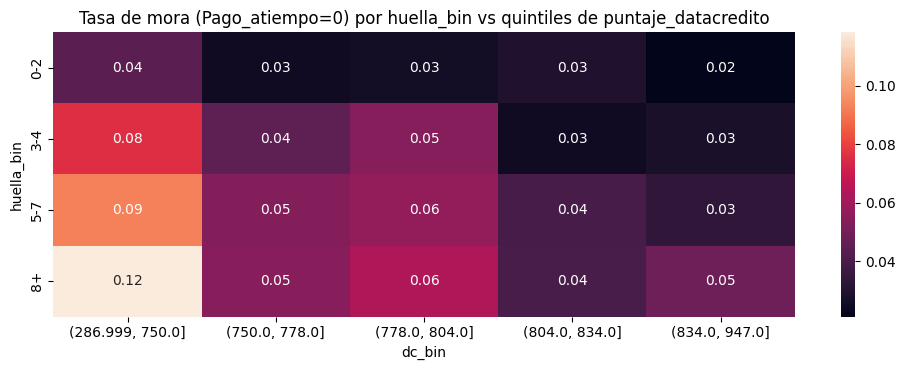

dc_bin,"(286.999, 750.0]","(750.0, 778.0]","(778.0, 804.0]","(804.0, 834.0]","(834.0, 947.0]"
huella_bin,,,,,
0-2,0.04,0.03,0.03,0.03,0.02
3-4,0.08,0.04,0.05,0.03,0.03
5-7,0.09,0.05,0.06,0.04,0.03
8+,0.12,0.05,0.06,0.04,0.05


In [24]:
tmp = df_fe[["huella_consulta","puntaje_datacredito",TARGET]].dropna().copy()

tmp["huella_bin"] = pd.cut(tmp["huella_consulta"], bins=[-0.1,2,4,7,100], labels=["0-2","3-4","5-7","8+"])
tmp["dc_bin"] = pd.qcut(tmp["puntaje_datacredito"], q=5, duplicates="drop")

pivot = tmp.pivot_table(index="huella_bin", columns="dc_bin", values=TARGET, aggfunc=lambda x: (x==0).mean(), observed=True)

plt.figure(figsize=(10, 3.8))
sns.heatmap(pivot, annot=True, fmt=".2f")
plt.title("Tasa de mora (Pago_atiempo=0) por huella_bin vs quintiles de puntaje_datacredito")
plt.tight_layout()
plt.show()

pivot


## **Heuristica brevesita**
Una heurística simple (sin entrenar) para mostrar cómo se podría clasificar riesgo.

> Ojo: el dataset está desbalanceado (mora ~4.75%), así que accuracy puede ser engañoso.


In [25]:
def heuristic_predict(row) -> int:
    # reglas simples (ajustables)
    dc = row.get("puntaje_datacredito", np.nan)
    huella = row.get("huella_consulta", np.nan)
    ratio = row.get("ratio_cuota_salario", np.nan)

    # imputación simple para no romper (medianas)
    if pd.isna(dc): dc = med_dc
    if pd.isna(huella): huella = med_huella
    if pd.isna(ratio): ratio = med_ratio

    # si hay señales de riesgo, predice mora (0); si no, al día (1)
    if (dc < 760) or (huella >= 8) or (ratio > 0.35):
        return 0
    return 1

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# preparar medianas para imputación simple
med_dc = df_fe["puntaje_datacredito"].median()
med_huella = df_fe["huella_consulta"].median()
med_ratio = df_fe["ratio_cuota_salario"].median()

y_true = df_fe[TARGET].values
y_pred = df_fe.apply(heuristic_predict, axis=1).values

print("Heurística — accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=3))
confusion_matrix(y_true, y_pred)


Heurística — accuracy: 0.6692372015237388
              precision    recall  f1-score   support

           0      0.071     0.491     0.124       511
           1      0.964     0.678     0.796     10252

    accuracy                          0.669     10763
   macro avg      0.517     0.585     0.460     10763
weighted avg      0.922     0.669     0.764     10763



array([[ 251,  260],
       [3300, 6952]])

### ⚠️ Chequeo rápido: `puntaje` parece demasiado perfecto
Si ves que por encima de cierto umbral la mora es ~0% y casi todos los registros están allí, puede ser señal de variable derivada del resultado (*leakage*).

In [26]:
if "puntaje" in df_raw.columns:
    tmp = df_raw[["puntaje", TARGET]].copy()
    tmp["puntaje_bucket"] = pd.cut(tmp["puntaje"], bins=[-np.inf, 90, 95, np.inf], labels=["<90", "90-95", ">95"])
    leak = tmp.groupby("puntaje_bucket", observed=True)[TARGET].agg(
        mora_rate=lambda x: (x==0).mean(),
        n="size"
    )
    display(leak)


,mora_rate,n
puntaje_bucket,,
<90,0.49,1044
90-95,0.00,312
>95,0.00,9407


## Exportar dataset limpio

In [27]:
OUT_CSV = "Base_de_datos.csv"
df_fe.to_csv(OUT_CSV, index=False, encoding="utf-8")
print("✅ Guardado:", OUT_CSV, "| filas:", len(df_fe), "| cols:", df_fe.shape[1])


✅ Guardado: Base_de_datos.csv | filas: 10763 | cols: 33


## **Analisis de los resultados y conclusiones**
Aquí generamos insights listos para tu informe/presentación (con tasas y tamaño de muestra).

In [28]:
def mora_rate(s):
    return (s == 0).mean()

insights = {}

# 1) mora global
insights["mora_global"] = (df_fe[TARGET] == 0).mean()

# 2) huella bins
tmp = df_fe[["huella_consulta", TARGET]].dropna().copy()
tmp["huella_bin"] = pd.cut(tmp["huella_consulta"], bins=[-0.1,2,4,7,100], labels=["0-2","3-4","5-7","8+"])
huella_tbl = tmp.groupby("huella_bin", observed=True)[TARGET].agg(mora_rate=mora_rate, n="size").sort_index()
insights["huella"] = huella_tbl

# 3) datacredito bins
tmp = df_fe[["puntaje_datacredito", TARGET]].dropna().copy()
tmp["dc_bin"] = pd.cut(tmp["puntaje_datacredito"], bins=[149,750,834,950], labels=["<=750","751-834",">=835"])
dc_tbl = tmp.groupby("dc_bin", observed=True)[TARGET].agg(mora_rate=mora_rate, n="size")
insights["datacredito"] = dc_tbl

# 4) tendencia ingresos
tmp = df_fe[["tendencia_ingresos", TARGET]].dropna().copy()
trend_tbl = tmp.groupby("tendencia_ingresos", observed=True)[TARGET].agg(mora_rate=mora_rate, n="size").sort_values("mora_rate", ascending=False)
insights["tendencia_ingresos"] = trend_tbl

# 5) edad bucket
tmp = df_fe[["edad_bucket", TARGET]].dropna().copy()
edad_tbl = tmp.groupby("edad_bucket", observed=True)[TARGET].agg(mora_rate=mora_rate, n="size")
insights["edad_bucket"] = edad_tbl

# 6) tipo laboral
tmp = df_fe[["tipo_laboral", TARGET]].dropna().copy()
lab_tbl = tmp.groupby("tipo_laboral", observed=True)[TARGET].agg(mora_rate=mora_rate, n="size")
insights["tipo_laboral"] = lab_tbl

print(f"📌 Mora global: {insights['mora_global']:.2%}\n")

print("🔹 Mora por huella_consulta (bins):")
display((insights["huella"] * [100,1]).rename(columns={"mora_rate":"mora_%"}))

print("🔹 Mora por puntaje_datacredito (bins):")
display((insights["datacredito"] * [100,1]).rename(columns={"mora_rate":"mora_%"}))

print("🔹 Mora por tendencia_ingresos:")
display((insights["tendencia_ingresos"] * [100,1]).rename(columns={"mora_rate":"mora_%"}))

print("🔹 Mora por edad_bucket:")
display((insights["edad_bucket"] * [100,1]).rename(columns={"mora_rate":"mora_%"}))

print("🔹 Mora por tipo_laboral:")
display((insights["tipo_laboral"] * [100,1]).rename(columns={"mora_rate":"mora_%"}))

📌 Mora global: 4.75%

🔹 Mora por huella_consulta (bins):


,mora_%,n
huella_bin,,
0-2,2.93,3415
3-4,4.49,3340
5-7,5.86,2626
8+,7.74,1382


🔹 Mora por puntaje_datacredito (bins):


,mora_%,n
dc_bin,,
<=750,8.53,2169
751-834,4.09,6336
>=835,2.67,2099


🔹 Mora por tendencia_ingresos:


,mora_%,n
tendencia_ingresos,,
Decreciente,6.27,1291
Estable,4.63,1188
Creciente,3.91,5294


🔹 Mora por edad_bucket:


,mora_%,n
edad_bucket,,
18-25,8.80,568
26-35,6.21,2723
36-45,4.03,3176
46-55,3.43,2216
56-65,4.17,1582
66+,3.16,348


🔹 Mora por tipo_laboral:


,mora_%,n
tipo_laboral,,
Empleado,4.29,6754
Independiente,5.51,4009


### ✅ Conclusiones
- La mora global es ~4.75%.
- **Huella de consulta** muestra tendencia clara: a mayor huella, mayor mora (0–2 vs 8+).
- **Puntaje DataCrédito** segmenta fuerte: score bajo (≤750) tiene mora considerablemente mayor que score alto (≥835).
- **Tendencia de ingresos**: *Decreciente* presenta más mora que *Creciente*.
- **Edad**: el bucket 18–25 es el más riesgoso.
- `puntaje` parece una variable derivada del resultado (posible *leakage*), por lo que no es recomendable para modelado al originar.
- Se proponen reglas de validación para fechas futuras y valores extremos (p1–p99) en variables monetarias.
